# ПРИНУДИТЕЛЬНОЕ ВЫРАВНИВАНИЕ С WAV2VEC2

Автор : Мото Хира

В этом руководстве показано, как сопоставить расшифровку с речью с torchaudioпомощью алгоритма сегментации CTC, описанного в CTC-сегментации больших корпусов для сквозного распознавания речи на русском языке .

In [1]:
import json
import torch
import torchaudio
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
import IPython
import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass
import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)


Загрузка модели

In [3]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [4]:
device_s = f"cuda" if torch.cuda.is_available() else "cpu"
print(f"using device {device_s}")
device = torch.device(device_s)


using device cpu


/home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
model = Wav2Vec2ForCTC.from_pretrained("./checkpoint-300")

In [6]:
model.to(device)
model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)

Общее количество параметров модели

In [7]:
sum([param.nelement() for param in model.parameters()])

94421697

Обзор
Процесс выравнивания выглядит следующим образом.

1) Оцените покадровую вероятность метки от аудиосигнала

2) Сгенерируйте решетчатую матрицу, которая представляет вероятность выравнивания меток на временном шаге.

3) Найдите наиболее вероятный путь из матрицы решетки.

4) В этом примере мы используем модель Wav2Vec2 для выделения акустических признаков.



Аудио файл для тестирования

In [8]:

fpath='1.wav'#'test.wav'

In [9]:
IPython.display.Audio(fpath)

Загрузка аудио

In [10]:
audio_input, sample_rate = torchaudio.load(fpath)
if audio_input.shape[0]>1:
        audio_input=torch.sum(audio_input,0)/audio_input.shape[0]
        audio_input=torch.unsqueeze(audio_input,0)

audio_input=audio_input
if  sample_rate !=16000:
        audio_input= F.resample(audio_input, sample_rate,16000)
        sample_rate =16000
audio_input=torch.squeeze(audio_input)

Вывод модели с жадным поиском

In [11]:
input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values
input_values=input_values.to(device)
with torch.inference_mode():
    emission = model(input_values).logits
    
    predicted_ids = torch.argmax(emission, dim=-1)
text=processor.decode(predicted_ids[0])
text

'привет как дела сколько время – расскажить с касло'

In [12]:
simvol={'m': 0,
 'ё': 1,
 'e': 2,
 'i': 3,
 'ж': 4,
 '‑': 5,
 's': 6,
 'я': 7,
 'р': 8,
 'м': 9,
 'н': 10,
 '«': 11,
 'й': 12,
 'g': 13,
 'т': 14,
 '–': 15,
 'k': 16,
 'z': 17,
 '—': 18,
 'з': 19,
 "'": 20,
 'a': 21,
 'д': 22,
 'л': 23,
 '»': 24,
 'ч': 25,
 'с': 26,
 'б': 27,
 'h': 28,
 'c': 29,
 '(': 30,
 'и': 31,
 'l': 32,
 'щ': 33,
 'ф': 34,
 'o': 35,
 'ш': 36,
 'у': 37,
 'х': 38,
 'г': 39,
 'ц': 40,
 '…': 41,
 'ы': 42,
 'b': 43,
 'x': 44,
 'о': 45,
 'э': 46,
 'ъ': 47,
 'p': 48,
 'а': 49,
 'п': 50,
 'ю': 51,
 '−': 52,
 'е': 53,
 'в': 54,
 'ь': 55,
  '|': 56,      
 'r': 57,
 't': 58,
 'к': 59,
 ')': 60,
 'f': 61,
 'n': 62,
  '[UNK]': 63,
 '[PAD]': 64}
labels=list(simvol.keys())

Сгенерируйте покадровую вероятность метки.

Первым шагом является создание класса меток для каждого кадра аудио. 

В последующих разделах мы вычислим вероятность в логарифмической области, чтобы избежать численной нестабильности. Для этого мы нормализуем emissionwith torch.log_softmax().

In [13]:
with torch.inference_mode():
    waveform, _ = torchaudio.load(fpath)
    emissions = model(waveform.to(device))
    emissions = torch.log_softmax(emissions[0], dim=-1)

emission = emissions[0].cpu().detach()

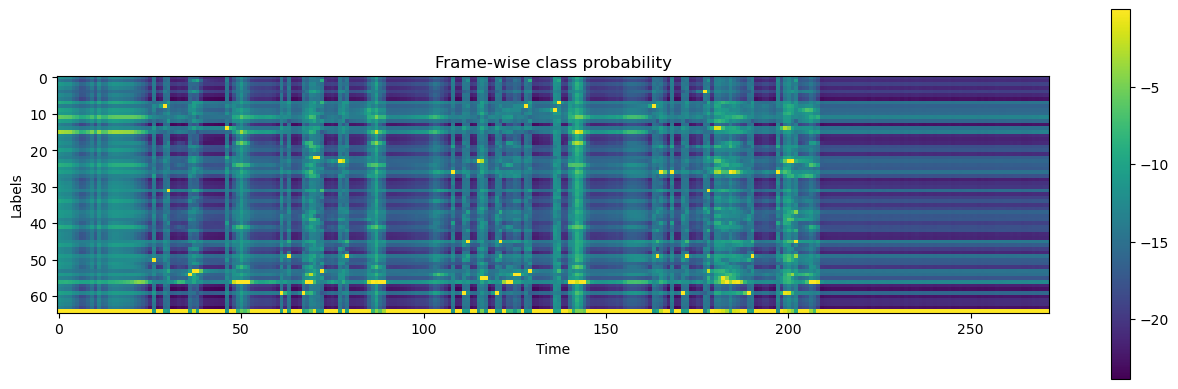

In [14]:
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

Создание вероятности выравнивания (решетка)

Затем из матрицы выбросов мы создаем решетку, которая представляет вероятность появления меток транскриптов в каждом временном интервале.

Решетка представляет собой двумерную матрицу с осью времени и осью меток. Ось меток представляет стенограмму, которую мы выравниваем. В дальнейшем мы используем t тдля обозначения индекса на оси времени и J для обозначения индекса на оси метки.c_jс 
j
​
 представляет метку в индексе метки j.

Чтобы сгенерировать, вероятность шага по временит+1т+1, смотрим на решетку с шага по временитти эмиссия на временном шагет+1т+1. Есть два пути достижения временного шагат+1т+1с этикеткой с_{j+1}с 
j + 1
​
 . Первый случай, когда метка была с_{j+1}с 
j + 1
​
 втти не было никакой смены лейбла с тткт+1т+1. Другой случай, когда метка была c_jс 
Дж
​
 втти он перешел к следующему ярлыку с_{j+1}с 
j + 1
​
 вт+1т+1.

Следующая диаграмма иллюстрирует этот переход.


![title](./img/ctc-forward.png)

Поскольку мы ищем наиболее вероятные переходы, мы выбираем наиболее вероятный путь для значенияk_{(t+1, j+1)}к 
( т + 1 , j + 1 )
​
 , то есть

k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t +1, повтор))к 
( т + 1 , j + 1 )
​
 знак равномакс х ( к 
( т , j )
​
 р ( т+1 ,с 
j + 1
​
 ) ,к 
( т , j + 1 )
​
 р ( т+1 ,повтор ) ) _ _ _

кудаккпредставляет собой решетчатую матрицу, ар (т, с_j)р ( т ,с 
j
​
 ) представляет вероятность меткиc_jс 
j
​
 на временном шагетт. повторениеповторить _ _ _ _представляет пустой токен из формулировки CTC. (Для получения подробной информации об алгоритме CTC см. Моделирование последовательности с помощью CTC [ distill.pub ])

In [16]:
# transcript =text.replace(" ",'|')
transcript = "|привет|как|дела|сколько|время|расскажи|сказку"

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=64):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

   #Trellis имеет дополнительные размеры как для оси времени, так и для токенов.
# Дополнительный размер токенов представляет собой <SoS> (начало предложения)
# Дополнительный размер оси времени для упрощения кода.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)


[('|', 56), ('п', 50), ('р', 8), ('и', 31), ('в', 54), ('е', 53), ('т', 14), ('|', 56), ('к', 59), ('а', 49), ('к', 59), ('|', 56), ('д', 22), ('е', 53), ('л', 23), ('а', 49), ('|', 56), ('с', 26), ('к', 59), ('о', 45), ('л', 23), ('ь', 55), ('к', 59), ('о', 45), ('|', 56), ('в', 54), ('р', 8), ('е', 53), ('м', 9), ('я', 7), ('|', 56), ('р', 8), ('а', 49), ('с', 26), ('с', 26), ('к', 59), ('а', 49), ('ж', 4), ('и', 31), ('|', 56), ('с', 26), ('к', 59), ('а', 49), ('з', 19), ('к', 59), ('у', 37)]


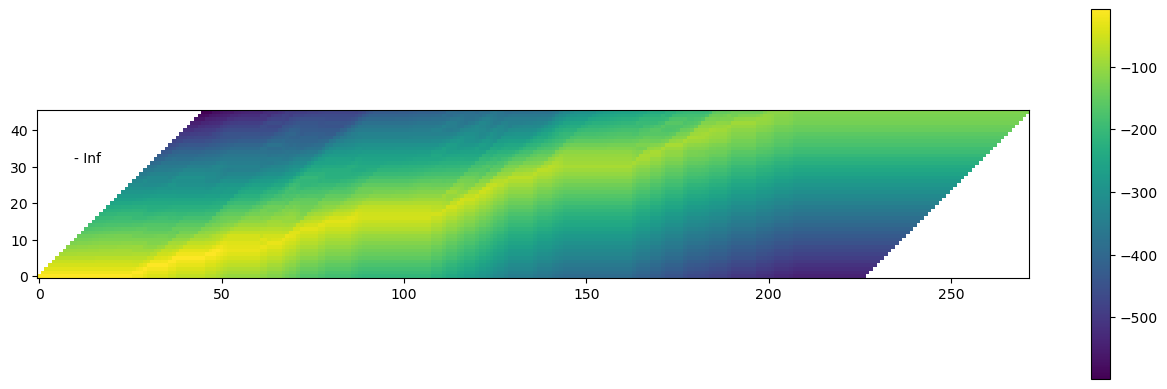

In [17]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

На приведенной выше визуализации мы видим, что есть след с высокой вероятностью, пересекающий матрицу по диагонали.

Найти наиболее вероятный путь (возврат)
Как только решетка сгенерирована, мы будем проходить ее, следуя элементам с высокой вероятностью.

Мы начнем с последнего индекса метки с временным шагом наибольшей вероятности, затем вернемся назад во времени, выбрав остаться (c_j \стрелка вправо c_jс 
Дж
​
 →с 
Дж
​
 ) или переход (c_j \стрелка вправо c_{j+1}с 
Дж
​
 →с 
j + 1
​
 ), исходя из постпереходной вероятностиk_{t, j} p(t+1, c_{j+1})к 
т , Дж
​
 р ( т+1 ,с 
j + 1
​
 )или же k_{t, j+1} p(t+1, повтор)к 
т , j + 1
​
 р ( т+1 ,повтор ) _ _ _ _.

Переход выполняется, когда метка достигает начала.

Для поиска пути используется решетчатая матрица, но для окончательной вероятности каждого сегмента мы берем покадровую вероятность из матрицы выбросов.

In [18]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=64):
    # Note:
    # Примечание:
    # j и t - индексы решетки, которая имеет дополнительные измерения
    # для времени и токенов в начале.
    # Когда речь идет об индексе таймфрейма `T` в решетке,
    # соответствующий индекс в эмиссии `Т-1`.
    # Точно так же, когда речь идет об индексе токена `J` в решетке,
    # соответствующий индекс в расшифровке - `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Выясните, была ли текущая позиция неизменной или измененной
        # Примечание (еще раз):
        # `выброс[J-1]` - это выброс во временном интервале `J` размерности решетки.
        # Оценка токена остается неизменной от временного интервала J-1 до T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Оценка за изменение токена с C-1 в T-1 на J в T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.00015956531569827348)
Point(token_index=0, time_index=1, score=5.526567292690743e-06)
Point(token_index=0, time_index=2, score=3.612133923525107e-06)
Point(token_index=0, time_index=3, score=3.226075477869017e-06)
Point(token_index=0, time_index=4, score=7.225521585496608e-07)
Point(token_index=0, time_index=5, score=2.8503089311016083e-07)
Point(token_index=0, time_index=6, score=5.130465652314342e-08)
Point(token_index=0, time_index=7, score=6.565746701880926e-08)
Point(token_index=0, time_index=8, score=2.2048577363875665e-07)
Point(token_index=0, time_index=9, score=1.307725483457034e-06)
Point(token_index=0, time_index=10, score=8.425440967130271e-08)
Point(token_index=0, time_index=11, score=3.3133876513602445e-06)
Point(token_index=0, time_index=12, score=2.7334067453921307e-07)
Point(token_index=0, time_index=13, score=3.9447903077416413e-07)
Point(token_index=0, time_index=14, score=2.9541492949647363e-06)
Point(token_index=0, time_in

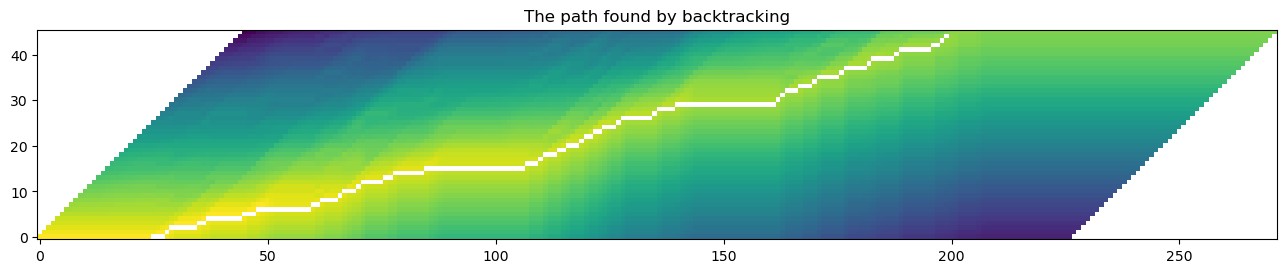

In [19]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [20]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(0.00): [    0,    26)
п	(0.33): [   26,    29)
р	(1.00): [   29,    30)
и	(0.17): [   30,    36)
в	(0.50): [   36,    38)
е	(0.12): [   38,    46)
т	(0.33): [   46,    49)
|	(0.08): [   49,    61)
к	(0.50): [   61,    63)
а	(0.25): [   63,    67)
к	(1.00): [   67,    68)
|	(0.33): [   68,    71)
д	(1.00): [   71,    72)
е	(0.20): [   72,    77)
л	(0.50): [   77,    79)
а	(0.14): [   79,    86)
|	(0.05): [   86,   108)
с	(0.33): [  108,   111)
к	(1.00): [  111,   112)
о	(0.33): [  112,   115)
л	(0.50): [  115,   117)
ь	(0.33): [  117,   120)
к	(1.00): [  120,   121)
о	(0.50): [  121,   123)
|	(0.50): [  123,   125)
в	(0.33): [  125,   128)
р	(1.00): [  128,   129)
е	(0.14): [  129,   136)
м	(1.00): [  136,   137)
я	(0.25): [  137,   141)
|	(0.04): [  141,   163)
р	(1.00): [  163,   164)
а	(1.00): [  164,   165)
с	(0.30): [  165,   168)
с	(0.33): [  168,   171)
к	(1.00): [  171,   172)
а	(0.20): [  172,   177)
ж	(1.00): [  177,   178)
и	(0.17): [  178,   183)
|	(0.94): [  183,   184)


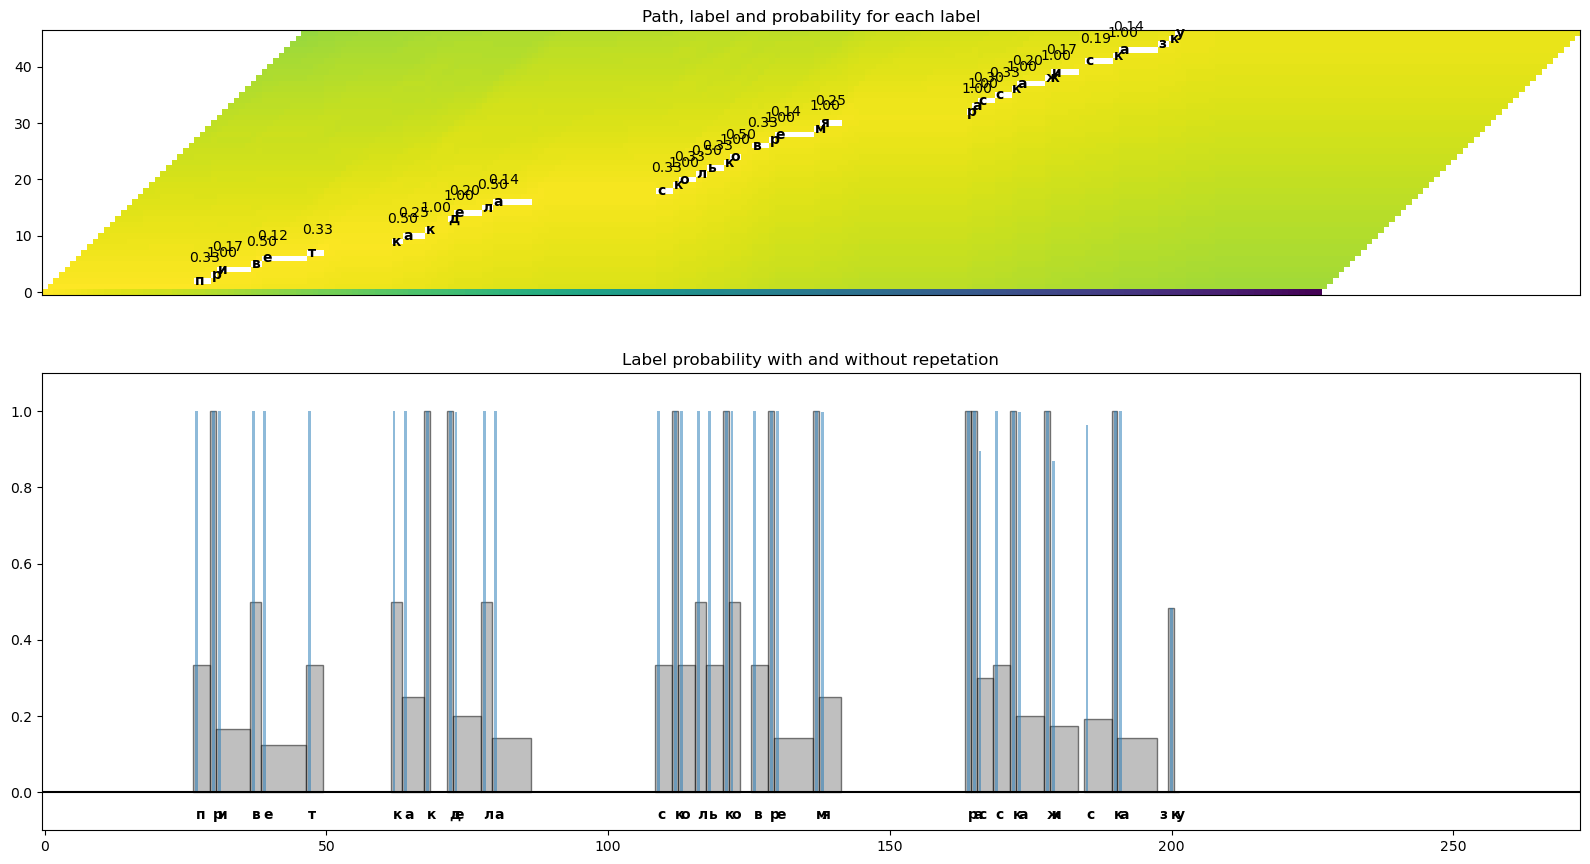

In [21]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [22]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

привет	(0.26): [   26,    49)
как	(0.43): [   61,    68)
дела	(0.27): [   71,    86)
сколько	(0.47): [  108,   123)
время	(0.31): [  125,   141)
расскажи	(0.39): [  163,   183)
сказку	(0.20): [  184,   201)


In [23]:
 waveform, _ = torchaudio.load(fpath)

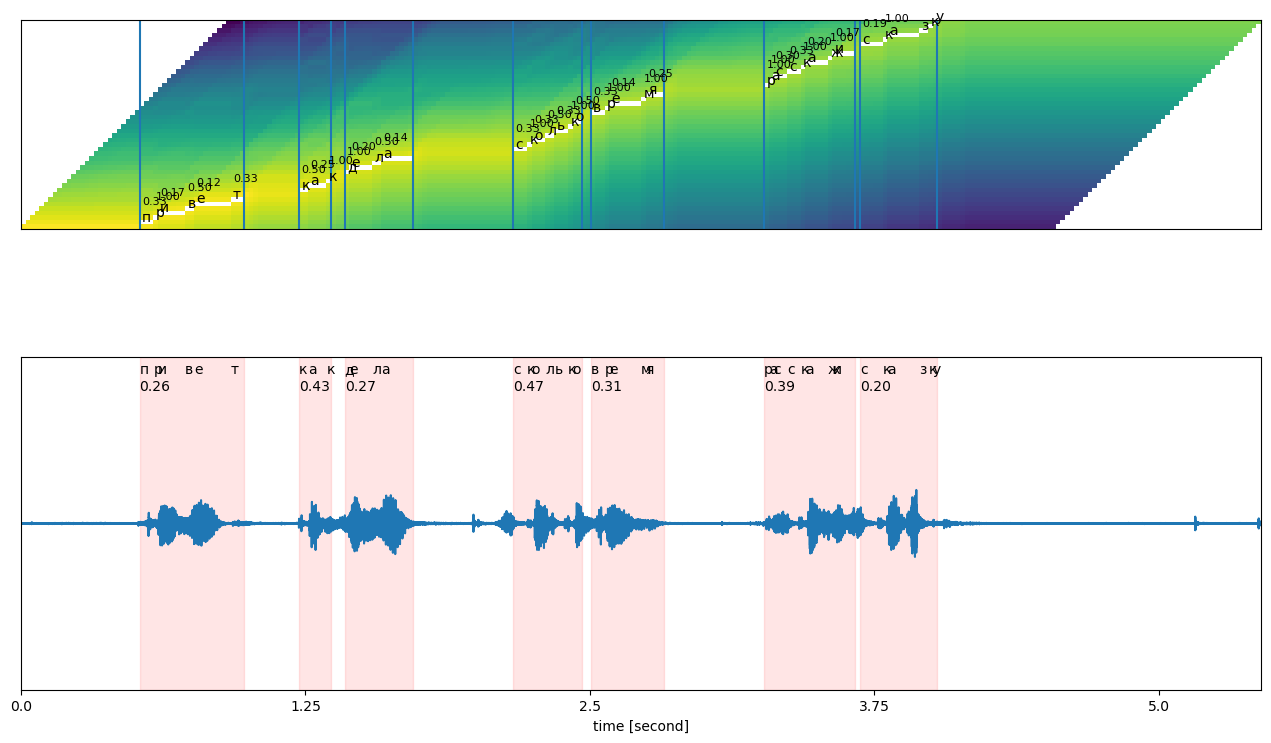

In [24]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / 16000)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()

In [25]:
IPython.display.Audio(fpath)